In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.utils import RULE_DEFAULT, RULE_KEEP
from gensim.models.callbacks import CallbackAny2Vec

In [2]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
filtered_concept_arr = np.unique(np.load("saved_files/overlapping_filtered_5_concepts.npy"))
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

In [3]:
# def compute_word_count_subset(corpus, subset_words):
    
#     for document in tqdm(corpus):
#         for word in document:
#             if word in subset_words:
#                 subset_words[word] += 1
#     return subset_words

# # Compute word count for the subset of words 
# word_count_subset = compute_word_count_subset([row.split() for row in ngram_abstracts], {k:0 for k in np.unique(concept_arr)})

# def filter_dict_by_occurrence(word_count_dict, n):
#     return {word: count for word, count in word_count_dict.items() if count > n}

# filtered_concept_dict = np.array(list(filter_dict_by_occurrence(word_count_subset, 4).keys()))

In [4]:
df_ab = pd.DataFrame(data=ngram_abstracts,    # values
                columns=["ab"])  # 1st row as the column names
df_ab["year"] = year_arr

In [5]:
# Define important words
phys_concept_dict = {k:1 for k in filtered_concept_arr}

# Custom rule function
def custom_rule(word, count, min_count):
    if word in phys_concept_dict:
        return RULE_KEEP
    else:
        return RULE_DEFAULT

cores = multiprocessing.cpu_count()

class LossLogger(CallbackAny2Vec):
    '''Callback to log loss after each epoch.'''
    def __init__(self):
        self.epoch = 0
        self.losses = []
        self.previous_loss = 0
        self.initial_loss = 0

    def on_epoch_begin(self, model):
        # Record the initial loss at the start of each epoch
        self.initial_loss = model.get_latest_training_loss()

    def on_epoch_end(self, model):
        current_loss = model.get_latest_training_loss()
        # Calculate the loss for the current epoch
        loss = current_loss - self.initial_loss
        self.losses.append(loss)
        self.initial_loss = current_loss  # Reset for the next epoch
        self.epoch += 1

loss_logger = LossLogger()

w2v_model = Word2Vec(min_count=5,
                     window=15,
                     vector_size=128,
                     sample=1e-4, 
                     alpha=0.01, 
                     min_alpha= 0.0001, 
                     negative=15,
                     workers=cores-1)


for year in np.unique(year_arr):
    print(f"Processing year: {year}")
    
    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] <= int(year)]["ab"].to_numpy()]

    if year == np.unique(year_arr)[0]:
        # Build the vocabulary on the first year's data
        w2v_model.build_vocab(ngram_abstracts_year, trim_rule=custom_rule)
        
    else:
        # Update the vocabulary with the current year's data
        w2v_model.build_vocab(ngram_abstracts_year, update=True, trim_rule=custom_rule)
    
    # Train the model on the current year's data
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=50, compute_loss=True, callbacks=[loss_logger])
    w2v_model.save(f"saved_models/model_year_{year}.model")

Processing year: 1994
Processing year: 1995
Processing year: 1996
Processing year: 1997
Processing year: 1998
Processing year: 1999
Processing year: 2000
Processing year: 2001
Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023


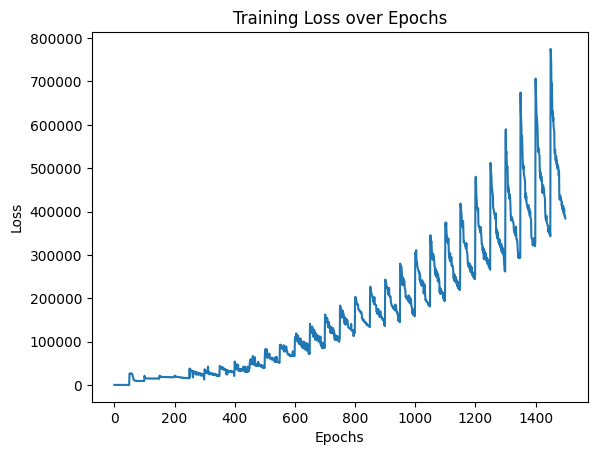

In [6]:
# Plot the training loss
plt.plot(loss_logger.losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# version 2: No retrain

In [7]:
loss_logger = LossLogger()

w2v_model = Word2Vec(min_count=5,
                     window=15,
                     vector_size=128,
                     sample=1e-4, 
                     alpha=0.01, 
                     min_alpha= 0.0001, 
                     negative=15,
                     workers=cores-1)


for year in np.unique(year_arr):
    print(f"Processing year: {year}")
    
    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] == int(year)]["ab"].to_numpy()]

    if year == np.unique(year_arr)[0]:
        # Build the vocabulary on the first year's data
        w2v_model.build_vocab(ngram_abstracts_year, trim_rule=custom_rule)
        
    else:
        # Update the vocabulary with the current year's data
        w2v_model.build_vocab(ngram_abstracts_year, update=True, trim_rule=custom_rule)
    
    # Train the model on the current year's data
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=50, compute_loss=True, callbacks=[loss_logger])
    w2v_model.save(f"saved_models/re_model_year_{year}.model")

Processing year: 1994
Processing year: 1995
Processing year: 1996
Processing year: 1997
Processing year: 1998
Processing year: 1999
Processing year: 2000
Processing year: 2001
Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023
